reading timestamps to filter out ones we are interested in

In [26]:
import pandas as pd

timestamps_data = pd.read_csv("data_csv/timestamps_ext.csv")
timestamps_data.drop(columns=[f"p{i}_championId" for i in range(1, 11)], inplace=True)
target = pd.read_csv("data_csv/first_win.csv")
target.columns = ["matchId", "first_win"]
data = timestamps_data.merge(target, on="matchId")
del target

with open("data_csv/timestamps_ext_columns.txt", "w") as f:
    f.write( "\n".join(timestamps_data.columns))
data_cleaned = data.dropna()
del timestamps_data

In [27]:
timestamps_starting = data_cleaned[data_cleaned["timeStamp"] == 0]
timestamps_20p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.2).abs().idxmin()
    )
]
timestamps_40p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.4).abs().idxmin()
    )
]
timestamps_60p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.6).abs().idxmin()
    )
]
timestamps_80p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.8).abs().idxmin()
    )
]
timestamps_100p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 1.0).abs().idxmin()
    )
]


In [28]:
#make data_cleaned only include whats in timestamps_starting .. 100

data_cleaned = pd.concat(
    [timestamps_starting, timestamps_20p, timestamps_40p, timestamps_60p, timestamps_80p, timestamps_100p]
)

loading matches data to filtered timestamps

In [29]:
matches_data = pd.read_csv("data_csv/matches.csv")
with open("data_csv/match_columns.txt","w") as f:
    f.write("\n".join(matches_data.columns))
    
columns = [] 
columns.extend([f"p{i}_teamPosition" for i in range(1, 11)])
columns.extend([f"p{i}_summonerLevel" for i in range(1, 11)])
columns.extend([f"p{i}_summoner1Id" for i in range(1, 11)])
columns.extend([f"p{i}_summoner2Id" for i in range(1, 11)])
columns.extend([f"p{i}_role" for i in range(1, 11)])
columns.extend([f"p{i}_lane" for i in range(1, 11)])
columns.extend([f"p{i}_individualPosition" for i in range(1, 11)])
columns.extend([f"p{i}_championId" for i in range(1, 11)])
columns.extend(["matchId","gameId","gameVersion", "gameCreation","gameStartTimestamp","gameEndTimestamp", "gameDuration" ])


matches_data = matches_data[columns]
for c in columns:
    print(c)
    print(matches_data[c].head())
    print("\n")

print(len(matches_data.columns))
data_cleaned = data_cleaned.merge(matches_data, on="matchId")
print(len(data_cleaned.columns))
#del matches_data
#call garbagecollector 
import gc
gc.collect()

p1_teamPosition
0    TOP
1    TOP
2    TOP
3    TOP
4    TOP
Name: p1_teamPosition, dtype: object


p2_teamPosition
0    JUNGLE
1    JUNGLE
2    JUNGLE
3    JUNGLE
4    JUNGLE
Name: p2_teamPosition, dtype: object


p3_teamPosition
0    MIDDLE
1    MIDDLE
2    MIDDLE
3    MIDDLE
4    MIDDLE
Name: p3_teamPosition, dtype: object


p4_teamPosition
0    BOTTOM
1    BOTTOM
2    BOTTOM
3    BOTTOM
4    BOTTOM
Name: p4_teamPosition, dtype: object


p5_teamPosition
0    UTILITY
1    UTILITY
2    UTILITY
3    UTILITY
4    UTILITY
Name: p5_teamPosition, dtype: object


p6_teamPosition
0    TOP
1    TOP
2    TOP
3    TOP
4    TOP
Name: p6_teamPosition, dtype: object


p7_teamPosition
0    JUNGLE
1    JUNGLE
2    JUNGLE
3    JUNGLE
4    JUNGLE
Name: p7_teamPosition, dtype: object


p8_teamPosition
0    MIDDLE
1    MIDDLE
2    MIDDLE
3    MIDDLE
4    MIDDLE
Name: p8_teamPosition, dtype: object


p9_teamPosition
0    BOTTOM
1    BOTTOM
2    BOTTOM
3    BOTTOM
4    BOTTOM
Name: p9_teamPosition, dtype:

177

In [30]:
print(len(data_cleaned.columns))

551


if matches.csv is having player ids in columns 0-9 instead of 1-10 uncomment below and paste as first line whats in output into matches.csv

In [31]:
columns_to_drop = ["gameMode", "gameName", "gameType", "gameVersion", "mapId" ]
data_cleaned.drop(columns=columns_to_drop, inplace=True, errors="ignore")
data_cleaned.drop(columns= ["p{}_summonerId".format(i) for i in range(1, 11)], inplace=True, errors="ignore")
data_cleaned.drop(columns= ["p{}_championName".format(i) for i in range(1, 11)], inplace=True, errors="ignore")

columns_to_drop = ["p{}_win".format(i) for i in range(1, 11)]
data_cleaned.drop(columns=["p{}_win".format(i) for i in range(1,11)], inplace=True, errors="ignore")
data_cleaned.drop(columns=["p{}_nexusLost".format(i) for i in range(1,11)], inplace=True, errors="ignore")
data_cleaned.drop(columns=["p{}_nexusKills".format(i) for i in range(1,11)], inplace=True, errors="ignore")

data_cleaned.drop(columns= ["p{}_summonerName".format(i) for i in range(1, 11)], inplace=True, errors="ignore")
data_cleaned.drop(columns= ["p{}_riotIdTagline".format(i) for i in range(1, 11)], inplace=True, errors="ignore")
data_cleaned.drop(columns= ["tournamentCode"], inplace=True, errors="ignore")
data_cleaned.drop(columns= ["p{}_puuid".format(i) for i in range(1, 11)], inplace=True, errors="ignore")

In [32]:
len(data_cleaned.columns)

550

In [33]:
#reset index
data_cleaned.reset_index(drop=True, inplace=True)
print(data_cleaned.shape)

(145302, 550)


In [34]:
del timestamps_100p
del timestamps_80p
del timestamps_60p
del timestamps_40p
del timestamps_20p
del timestamps_starting
gc.collect()

0

In [35]:
#show how many Na values are in each column and order them by the number of Na values
na_values = data_cleaned.isna().sum().sort_values(ascending=False)
print(na_values)

p8_teamPosition                          18
p5_teamPosition                          12
p1_teamPosition                           6
matchId                                   0
p6_damageStats_magicDamageTaken           0
                                         ..
p6_championStats_bonusMagicPenPercent     0
p5_championStats_bonusMagicPenPercent     0
p4_championStats_bonusMagicPenPercent     0
p3_championStats_bonusMagicPenPercent     0
gameDuration_y                            0
Length: 550, dtype: int64


In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"   Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}\n")
    return accuracy


models = [
    LogisticRegression(random_state=42, n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    HistGradientBoostingClassifier(random_state=42),
]

In [37]:
from sklearn.model_selection import cross_val_score


def cross_val_model(model, X, y):
    # Perform cross-validation and get accuracy scores
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring="accuracy")
    # Print the model's class name
    print(f"Model: {model.__class__.__name__}")
    # Print all cross-validation scores
    print(f"Cross-validation scores (Accuracy): {scores}")
    # Print the mean cross-validation score
    print(f"Mean cross-validation score (Accuracy): {scores.mean():.4f}\n")

In [38]:
def test_timestamp(timestamp):
    X, y, name = timestamp
    print("Timestamp at {} percent\n".format(name))
    accuracies = []
    for model in models:
        accuracies.append(evaluate_model(model, X, y))
    return accuracies
    # uncomment to also test with cross_validation - takes more time and results are similar so I left it commented out for now
    # for model in models:
    #     cross_val_model(model, X, y)

In [39]:
import regex as re
others = ['matchId', 'timeStamp', 'percentTimeStamp', "gameDuration"]

blue_team_pattern = re.compile(r'p[1-5]_(.*)')
red_team_pattern = re.compile(r'p(6|7|8|9|10)_(.*)')

blue_team_columns = {}
red_team_columns = {}


cols_to_onehot_encode = []
cols_to_onehot_encode.extend([f"p{i}_teamPosition" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_role" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_lane" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_individualPosition" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_summoner1Id" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_summoner2Id" for i in range(1, 11)])
cols_to_onehot_encode.extend([f"p{i}_championId" for i in range(1, 11)])


for col in data_cleaned.columns:
    if col not in cols_to_onehot_encode:
        if blue_team_pattern.match(col):
            feature_name = blue_team_pattern.match(col).group(1)
            if feature_name not in blue_team_columns:
                blue_team_columns[feature_name] = []
            blue_team_columns[feature_name].append(col)
        elif red_team_pattern.match(col):
            feature_name = red_team_pattern.match(col).group(2)
            if feature_name not in red_team_columns:
                red_team_columns[feature_name] = []
            red_team_columns[feature_name].append(col)

def aggregate_team_columns(data, team_columns, team_prefix):
    for feature, columns in team_columns.items():
        aggregated_column = f'{team_prefix}_{feature}'
        data[aggregated_column] = data[columns].sum(axis=1)
        print(aggregated_column)
    return data

data_cleaned = aggregate_team_columns(data_cleaned, blue_team_columns, 'blue').copy()
data_cleaned = aggregate_team_columns(data_cleaned, red_team_columns, 'red').copy()

blue_currentGold
blue_goldPerSecond
blue_jungleMinionsKilled
blue_level
blue_minionsKilled
blue_participantId
blue_timeEnemySpentControlled
blue_totalGold
blue_xp
blue_championStats_abilityHaste
blue_championStats_abilityPower
blue_championStats_armor
blue_championStats_armorPen
blue_championStats_armorPenPercent
blue_championStats_attackDamage
blue_championStats_attackSpeed
blue_championStats_bonusArmorPenPercent
blue_championStats_bonusMagicPenPercent
blue_championStats_ccReduction
blue_championStats_cooldownReduction
blue_championStats_health
blue_championStats_healthMax
blue_championStats_healthRegen
blue_championStats_lifesteal
blue_championStats_magicPen
blue_championStats_magicPenPercent
blue_championStats_magicResist
blue_championStats_movementSpeed
blue_championStats_omnivamp
blue_championStats_physicalVamp
blue_championStats_power
blue_championStats_powerMax
blue_championStats_powerRegen
blue_championStats_spellVamp
blue_damageStats_magicDamageDone
blue_damageStats_magicDamag

champion_id one-hot encoding

In [40]:

print(data_cleaned["p1_role"].value_counts())
print(data_cleaned["p1_lane"].value_counts())

#make onehotencoding for all columns in cols_to_onehot_encode
data_cleaned = pd.get_dummies(data_cleaned, columns=cols_to_onehot_encode)


p1_role
SOLO       79872
NONE       37416
SUPPORT    13836
DUO        12984
CARRY       1194
Name: count, dtype: int64
p1_lane
TOP       84624
JUNGLE    37416
NONE      13380
MIDDLE     9126
BOTTOM      756
Name: count, dtype: int64


In [67]:
#merge onehot_encoded champion columns into one champion column per team
#get all columns that have championId in name
champion_columns = [col for col in data_cleaned.columns if "championId" in col]
champion_columns

red_regex = re.compile(r"p[1-5]_")
blue_regex = re.compile(r"p[6-9]|p10")

red_champion_columns = [col for col in champion_columns if red_regex.match(col)]   
blue_champion_columns = [col for col in champion_columns if blue_regex.match(col)]


print(red_champion_columns)
print(blue_champion_columns)

red_champions = sorted(list(set([ int(c.split("_")[2]) for c in red_champion_columns])))
blue_champions = sorted(list(set([ int(c.split("_")[2]) for c in blue_champion_columns])))

print(red_champions)
print(blue_champions)

champion_frame = pd.DataFrame()
for r in red_champions:
    this_champion_red_columns =  [col for col in red_champion_columns if col.endswith("_{}".format(r))] 
    champion_frame["red_champion_{}".format(r)] = data_cleaned[this_champion_red_columns].sum(axis=1)

for b in blue_champions:
    this_champion_blue_columns =  [col for col in blue_champion_columns if col.endswith("_{}".format(b))] 
    champion_frame["blue_champion_{}".format(b)] = data_cleaned[this_champion_blue_columns].sum(axis=1)

data_cleaned = pd.concat([data_cleaned, champion_frame], axis=1)
data_cleaned.drop(columns=champion_columns, inplace=True)
    

['p1_championId_1', 'p1_championId_2', 'p1_championId_3', 'p1_championId_4', 'p1_championId_5', 'p1_championId_6', 'p1_championId_7', 'p1_championId_8', 'p1_championId_9', 'p1_championId_10', 'p1_championId_11', 'p1_championId_12', 'p1_championId_13', 'p1_championId_14', 'p1_championId_15', 'p1_championId_16', 'p1_championId_17', 'p1_championId_18', 'p1_championId_19', 'p1_championId_20', 'p1_championId_21', 'p1_championId_22', 'p1_championId_23', 'p1_championId_24', 'p1_championId_25', 'p1_championId_26', 'p1_championId_27', 'p1_championId_28', 'p1_championId_29', 'p1_championId_30', 'p1_championId_31', 'p1_championId_32', 'p1_championId_33', 'p1_championId_34', 'p1_championId_35', 'p1_championId_36', 'p1_championId_37', 'p1_championId_38', 'p1_championId_39', 'p1_championId_40', 'p1_championId_41', 'p1_championId_42', 'p1_championId_43', 'p1_championId_44', 'p1_championId_45', 'p1_championId_48', 'p1_championId_50', 'p1_championId_51', 'p1_championId_53', 'p1_championId_54', 'p1_cham

E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\285546656.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  champion_frame["red_champion_{}".format(r)] = data_cleaned[this_champion_red_columns].sum(axis=1)
E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\285546656.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  champion_frame["red_champion_{}".format(r)] = data_cleaned[this_champion_red_columns].sum(axis=1)
E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\285546656.py:25: PerformanceWarning: DataFrame is 

In [68]:
assert (champion_frame.sum(axis=1) == 10).all()
#reallocate memory as its fragmented
data_cleaned = data_cleaned.copy()

In [69]:
def print_correlation_features(X,Y, target_name = "first_win"):
    correlations = X.corrwith(Y, numeric_only=True).sort_values(ascending=False)
    print(f"NaN correlations = {correlations.isna().sum()}")
    correlations.dropna(inplace=True)
    
    print("\nTop 20 features most positively correlated with {}:".format(target_name))
    print(correlations.head(20))

    print("\nTop 20 features most negatively correlated with {}:".format(target_name))
    #print tail in reverse order
    print(correlations.tail(20)[::-1])    

In [70]:
#find column with p1_role in it
role_columns = [c for c in data_cleaned.columns if "p1_role" in c]
print(role_columns)
print(data_cleaned["p1_role_CARRY"])

['p1_role_CARRY', 'p1_role_DUO', 'p1_role_NONE', 'p1_role_SOLO', 'p1_role_SUPPORT']
0         False
1         False
2         False
3         False
4         False
          ...  
145297    False
145298    False
145299    False
145300    False
145301    False
Name: p1_role_CARRY, Length: 145302, dtype: bool


In [71]:
print_correlation_features(data_cleaned.drop(columns="p1_role_CARRY"), data_cleaned["p1_role_CARRY"], target_name="p1_role_CARRY")
print_correlation_features(data_cleaned.drop(columns="p1_role_DUO"), data_cleaned["p1_role_DUO"], target_name="p1_role_DUO")
print_correlation_features(data_cleaned.drop(columns="p1_role_SOLO"), data_cleaned["p1_role_SOLO"], target_name="p1_role_SOLO")
print_correlation_features(data_cleaned.drop(columns="p1_role_NONE"), data_cleaned["p1_role_NONE"], target_name="p1_role_NONE")

e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NaN correlations = 85

Top 10 features most positively correlated with p1_role_CARRY:
p1_individualPosition_BOTTOM    0.450139
p1_teamPosition_BOTTOM          0.442566
p4_individualPosition_TOP       0.414630
p4_teamPosition_TOP             0.407281
p5_lane_TOP                     0.385323
p1_lane_BOTTOM                  0.317669
p4_role_SOLO                    0.177800
p2_lane_TOP                     0.154786
p4_lane_TOP                     0.130134
p1_summoner2Id_7                0.115004
dtype: float64

Top 10 features most negatively correlated with p1_role_CARRY:
p1_teamPosition_TOP            -0.185530
p1_individualPosition_TOP      -0.182589
p4_individualPosition_BOTTOM   -0.162907
p4_teamPosition_BOTTOM         -0.161579
p4_role_CARRY                  -0.116892
p1_role_SOLO                   -0.100570
p5_lane_BOTTOM                 -0.078599
p3_individualPosition_MIDDLE   -0.068324
p3_teamPosition_MIDDLE         -0.066749
p1_role_NONE                   -0.053605
dtype: float64


e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NaN correlations = 85

Top 10 features most positively correlated with p1_role_DUO:
p3_role_DUO                     0.597286
p1_lane_MIDDLE                  0.466630
p3_lane_TOP                     0.434780
p4_lane_TOP                     0.174953
p5_role_SOLO                    0.079231
p3_individualPosition_TOP       0.032489
p1_individualPosition_MIDDLE    0.032329
p1_teamPosition_MIDDLE          0.032208
p3_teamPosition_TOP             0.031968
p4_role_SOLO                    0.029948
dtype: float64

Top 10 features most negatively correlated with p1_role_DUO:
p3_role_SOLO      -0.430568
p1_role_SOLO      -0.346102
p3_lane_MIDDLE    -0.266160
p1_role_NONE      -0.184476
p1_lane_JUNGLE    -0.184476
p1_role_SUPPORT   -0.101623
p5_role_SUPPORT   -0.076555
p1_lane_TOP       -0.062907
p3_role_CARRY     -0.043606
p4_lane_BOTTOM    -0.041399
dtype: float64


e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NaN correlations = 85

Top 10 features most positively correlated with p1_role_SOLO:
p1_lane_TOP        0.863879
p3_lane_MIDDLE     0.377829
p3_role_SOLO       0.351761
p2_role_NONE       0.328411
p2_lane_JUNGLE     0.328411
p7_role_NONE       0.305248
p7_lane_JUNGLE     0.305248
p4_lane_BOTTOM     0.298898
p10_lane_BOTTOM    0.258807
p5_lane_BOTTOM     0.256965
dtype: float64

Top 10 features most negatively correlated with p1_role_SOLO:
p1_lane_JUNGLE    -0.650661
p1_role_NONE      -0.650661
p1_role_SUPPORT   -0.358432
p5_lane_NONE      -0.351867
p2_lane_NONE      -0.351867
p1_lane_NONE      -0.351867
p6_lane_NONE      -0.351867
p10_lane_NONE     -0.351867
p7_lane_NONE      -0.351867
p3_lane_NONE      -0.351867
dtype: float64


e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NaN correlations = 85

Top 10 features most positively correlated with p1_role_NONE:
p1_lane_JUNGLE     1.000000
p3_role_SOLO       0.197807
p7_lane_JUNGLE     0.169963
p7_role_NONE       0.169963
p3_lane_MIDDLE     0.150896
p6_lane_TOP        0.150722
p2_role_NONE       0.146238
p2_lane_JUNGLE     0.146238
p10_lane_BOTTOM    0.135494
p9_lane_BOTTOM     0.132091
dtype: float64

Top 10 features most negatively correlated with p1_role_NONE:
p1_lane_TOP       -0.695468
p1_role_SOLO      -0.650661
p1_role_SUPPORT   -0.191049
p10_lane_NONE     -0.187549
p9_lane_NONE      -0.187549
p8_lane_NONE      -0.187549
p7_lane_NONE      -0.187549
p6_lane_NONE      -0.187549
p5_lane_NONE      -0.187549
p4_lane_NONE      -0.187549
dtype: float64


In [72]:
#write collumns to file
with open("data_csv/data_cleaned_columns.txt","w") as f:
    f.write("\n".join(data_cleaned.columns))

In [73]:
models = [
    LogisticRegression(random_state=42, n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    HistGradientBoostingClassifier(random_state=42),
]

In [74]:
#load events data
events_data = pd.read_csv("data_csv/eventdata.csv")

events_data.head()


,THRESHOLD,matchId,BLUE_BUILDING_KILL_INHIBITOR_BUILDING,BLUE_BUILDING_KILL_TOWER_BUILDING,BLUE_CHAMPION_KILL,BLUE_FIRST_BLOOD,BLUE_MONSTER_KILL_MST_AIR_DRAGON,BLUE_MONSTER_KILL_MST_CHEMTECH_DRAGON,BLUE_MONSTER_KILL_MST_EARTH_DRAGON,BLUE_MONSTER_KILL_MST_ELDER_DRAGON,...,RED_MONSTER_KILL_MST_CHEMTECH_DRAGON,RED_MONSTER_KILL_MST_EARTH_DRAGON,RED_MONSTER_KILL_MST_ELDER_DRAGON,RED_MONSTER_KILL_MST_FIRE_DRAGON,RED_MONSTER_KILL_MST_HEXTECH_DRAGON,RED_MONSTER_KILL_MST_WATER_DRAGON,RED_MONSTER_KILL_MT_BARON_NASHOR,RED_MONSTER_KILL_MT_DRAGON,RED_MONSTER_KILL_MT_HORDE,RED_MONSTER_KILL_MT_RIFTHERALD
0,0.2,EUW1_6882416210,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.4,EUW1_6882416210,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
2,0.6,EUW1_6882416210,0,3,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0.8,EUW1_6882416210,0,3,16,0,0,0,0,0,...,1,0,0,1,0,0,0,2,3,1
4,1.0,EUW1_6882416210,0,6,17,0,0,0,0,0,...,1,0,0,1,0,0,1,2,3,1


In [75]:
timestamps_starting = data_cleaned[data_cleaned["timeStamp"] == 0]
#append event_data columns to timestamps_starting with 0 values
objective_columns = events_data.columns[2:]
for c in objective_columns:
    timestamps_starting[c] = 0

timestamps_20p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.2).abs().idxmin()
    )
].merge(events_data[events_data["THRESHOLD"] == 0.2 ], on="matchId")

timestamps_40p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.4).abs().idxmin()
    )
].merge(events_data[events_data["THRESHOLD"] == 0.4 ], on="matchId")
timestamps_60p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.6).abs().idxmin()
    )
].merge(events_data[events_data["THRESHOLD"] == 0.6 ], on="matchId")
timestamps_80p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 0.8).abs().idxmin()
    )
].merge(events_data[events_data["THRESHOLD"] == 0.8 ], on="matchId")
timestamps_100p = data_cleaned.loc[
    data_cleaned.groupby("matchId")["percentTimeStamp"].apply(
        lambda x: (x - 1.0).abs().idxmin()
    )
].merge(events_data[events_data["THRESHOLD"] == 1.0 ], on="matchId")



E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\2656027079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps_starting[c] = 0
E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\2656027079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps_starting[c] = 0
E:\Users\qesterius\AppData\Local\Temp\ipykernel_20824\2656027079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Index(['BLUE_BUILDING_KILL_INHIBITOR_BUILDING',
       'BLUE_BUILDING_KILL_TOWER_BUILDING', 'BLUE_CHAMPION_KILL',
       'BLUE_FIRST_BLOOD', 'BLUE_MONSTER_KILL_MST_AIR_DRAGON',
       'BLUE_MONSTER_KILL_MST_CHEMTECH_DRAGON',
       'BLUE_MONSTER_KILL_MST_EARTH_DRAGON',
       'BLUE_MONSTER_KILL_MST_ELDER_DRAGON',
       'BLUE_MONSTER_KILL_MST_FIRE_DRAGON',
       'BLUE_MONSTER_KILL_MST_HEXTECH_DRAGON',
       'BLUE_MONSTER_KILL_MST_WATER_DRAGON',
       'BLUE_MONSTER_KILL_MT_BARON_NASHOR', 'BLUE_MONSTER_KILL_MT_DRAGON',
       'BLUE_MONSTER_KILL_MT_HORDE', 'BLUE_MONSTER_KILL_MT_RIFTHERALD'],
      dtype='object')
Index(['RED_BUILDING_KILL_INHIBITOR_BUILDING',
       'RED_BUILDING_KILL_TOWER_BUILDING', 'RED_CHAMPION_KILL',
       'RED_FIRST_BLOOD', 'RED_MONSTER_KILL_MST_AIR_DRAGON',
       'RED_MONSTER_KILL_MST_CHEMTECH_DRAGON',
       'RED_MONSTER_KILL_MST_EARTH_DRAGON',
       'RED_MONSTER_KILL_MST_ELDER_DRAGON', 'RED_MONSTER_KILL_MST_FIRE_DRAGON',
       'RED_MONSTER_KILL_MST_HEXTECH

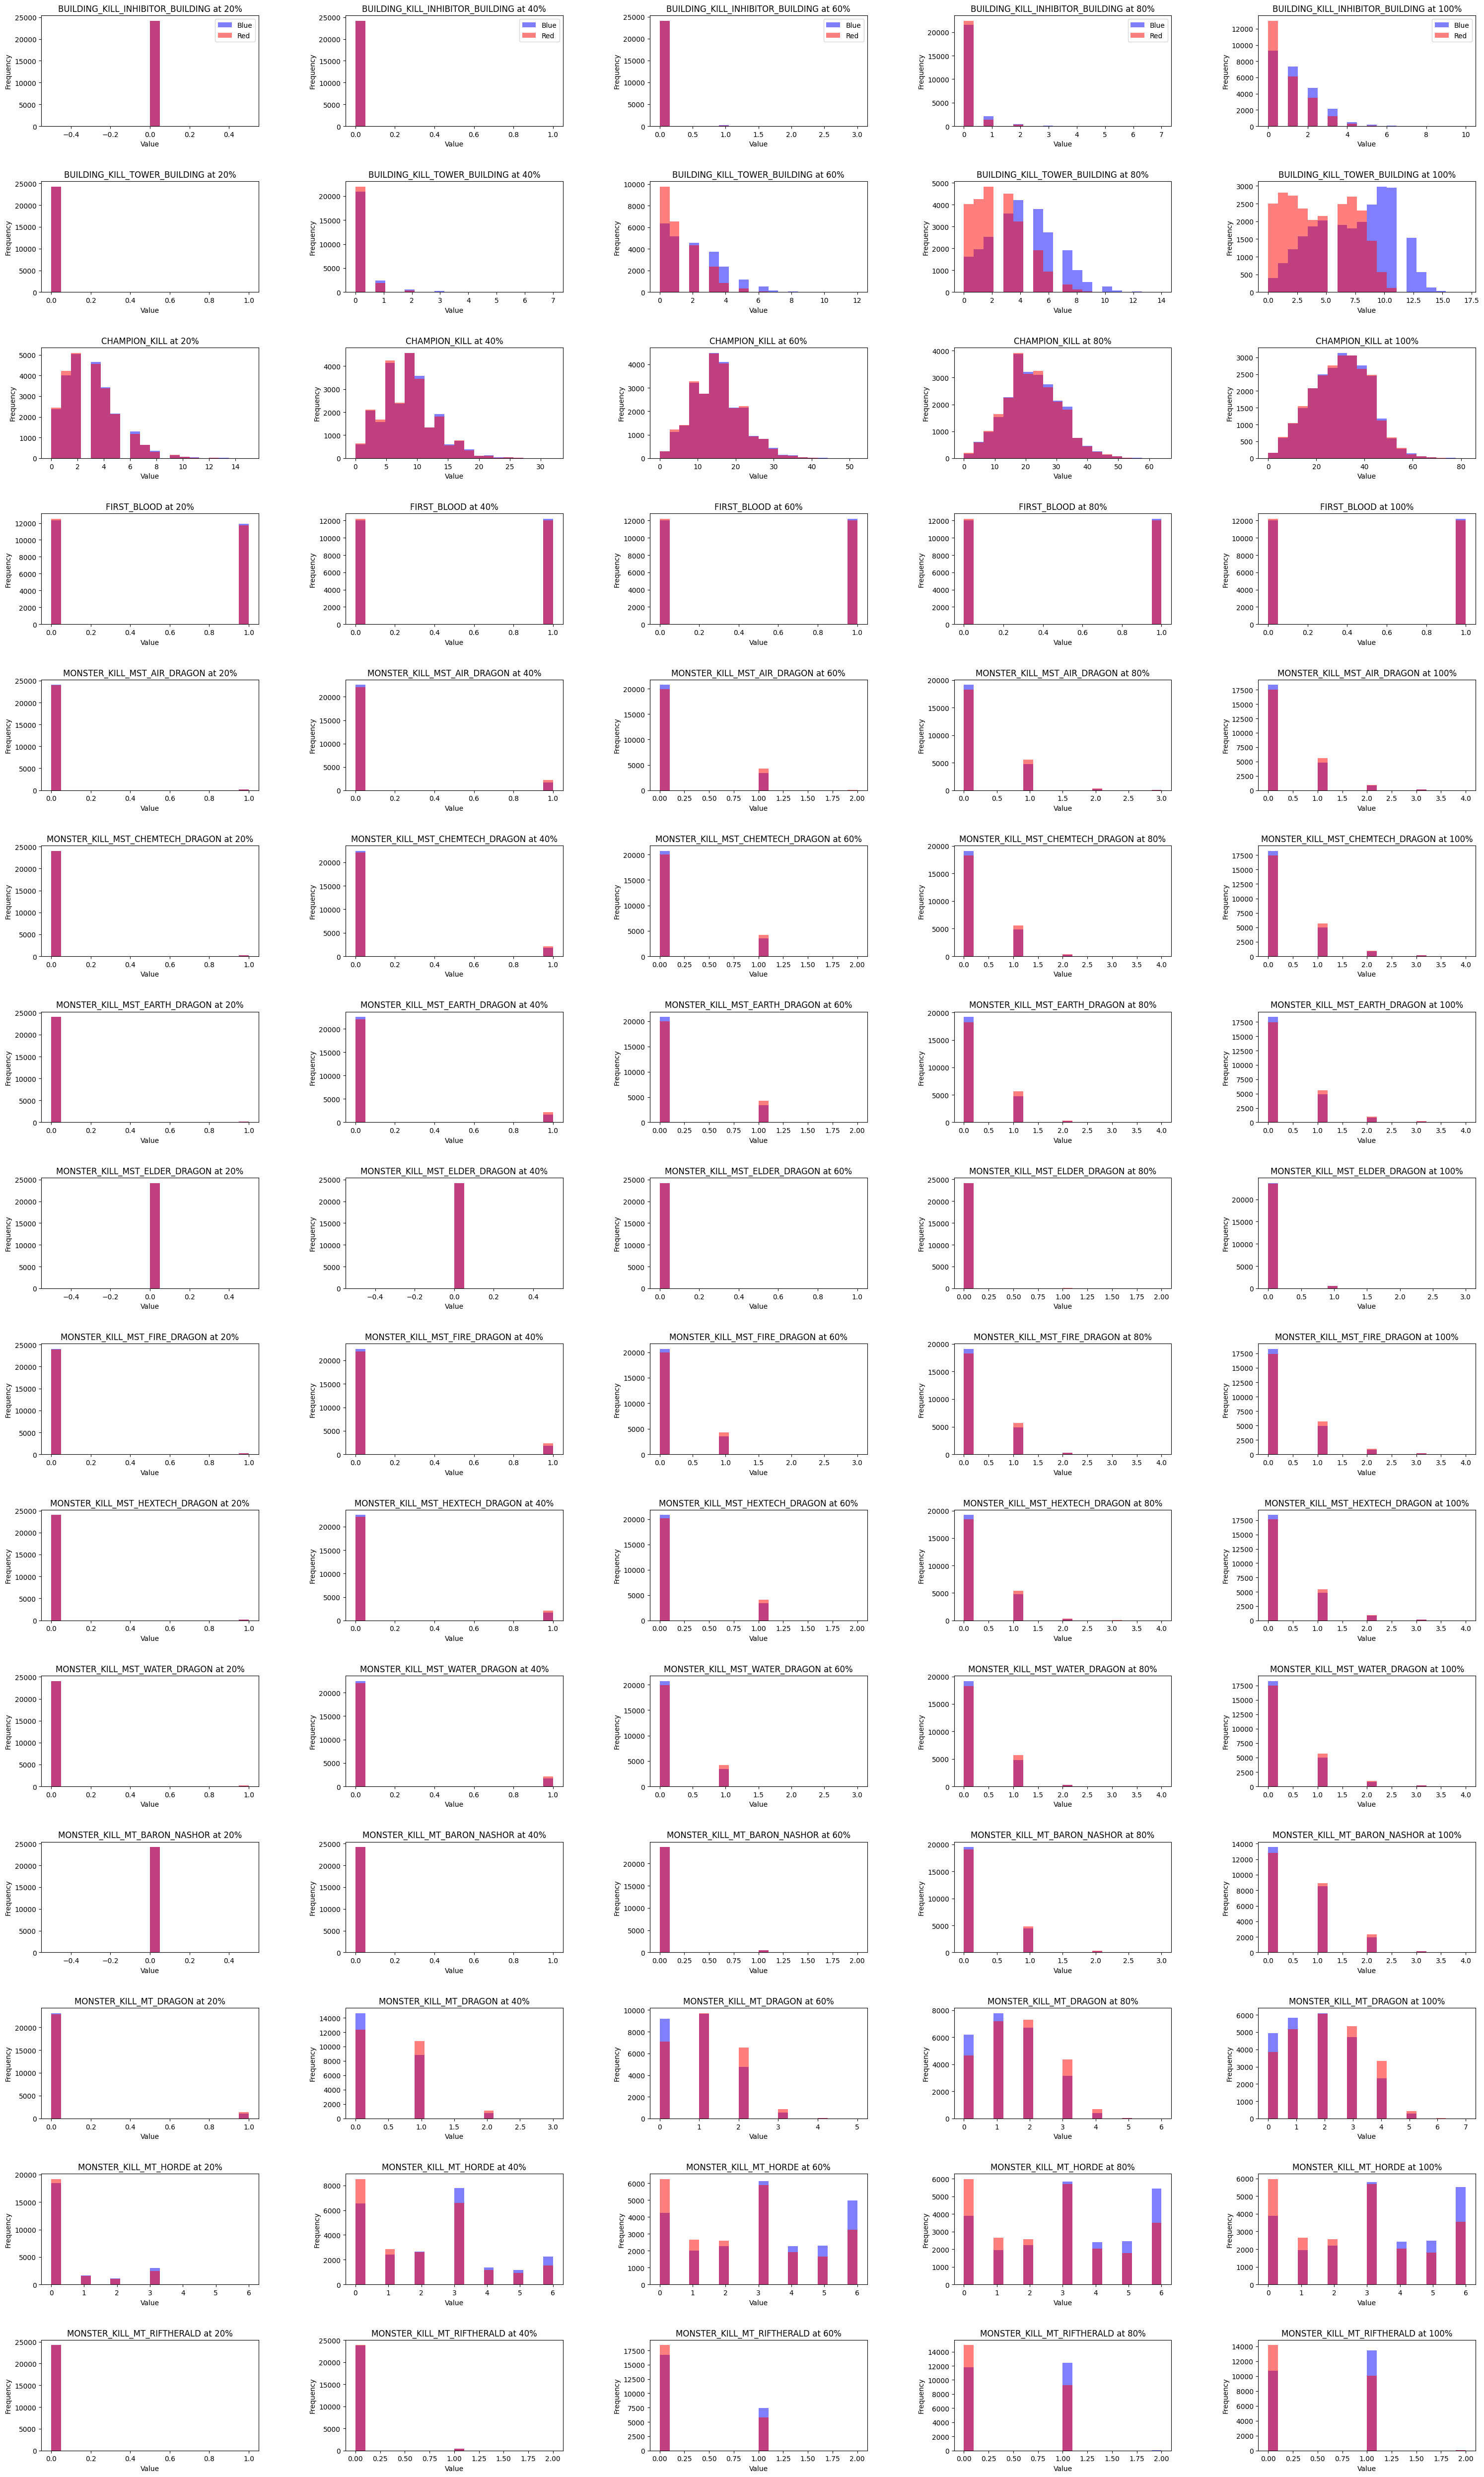

In [76]:
import matplotlib.pyplot as plt


blue_objective_columns = objective_columns[:15]
red_objective_columns = objective_columns[15:]
print(blue_objective_columns)
print(red_objective_columns)

timestamps_list = [
    (timestamps_20p, "20%"),
    (timestamps_40p, "40%"),
    (timestamps_60p, "60%"),
    (timestamps_80p, "80%"),
    (timestamps_100p, "100%"),
]
figure = plt.figure(figsize=(30, 50))


for ti, (timestamp, label) in enumerate(timestamps_list):
    for i in range(len(blue_objective_columns)):
        # Calculate the correct position in the 15x5 grid
        plot_index = 5 * i + ti + 1
        plt.subplot(15, 5, plot_index)
        common_range = (
            min(
                min(timestamp[blue_objective_columns[i]]),
                min(timestamp[red_objective_columns[i]]),
                ),
            max(
                max(timestamp[blue_objective_columns[i]]),
                max(timestamp[red_objective_columns[i]]),
                )
        )
        plt.hist(timestamp[blue_objective_columns[i]], bins=20, color="blue", alpha=0.5, label='Blue', range=common_range )
        plt.hist(timestamp[red_objective_columns[i]], bins=20, color="red", alpha=0.5, label='Red', range=common_range)
        col_unteamed = blue_objective_columns[i].removeprefix("BLUE_")
        plt.title(f"{col_unteamed} at {label}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        if i == 0:  # Add legend only for the first row to avoid repetition
            plt.legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.4)  # Adjust these parameters if needed


In [77]:
others = ["matchId"]

timestamps = []
X_0 = timestamps_starting.drop(columns=["first_win"] + others)
y_0 = timestamps_starting["first_win"]
timestamps.append((X_0, y_0, "0"))

X_20 = timestamps_20p.drop(columns=["first_win"] + others)
y_20 = timestamps_20p["first_win"]
timestamps.append((X_20, y_20, "20"))

X_40 = timestamps_40p.drop(columns=["first_win"] + others)
y_40 = timestamps_40p["first_win"]
timestamps.append((X_40, y_40, "40"))

X_60 = timestamps_60p.drop(columns=["first_win"] + others)
y_60 = timestamps_60p["first_win"]
timestamps.append((X_60, y_60, "60"))

X_80 = timestamps_80p.drop(columns=["first_win"] + others)
y_80 = timestamps_80p["first_win"]
timestamps.append((X_80, y_80, "80"))

X_100 = timestamps_100p.drop(columns=["first_win"]+ others)
y_100 = timestamps_100p["first_win"]
timestamps.append((X_100, y_100, "100"))

In [78]:

for ts, (X, Y)  in enumerate([(X_0, y_0), (X_20, y_20), (X_40, y_40), (X_60, y_60), (X_80, y_80), (X_100, y_100)]):
    print("Timestamp: ", ts*20)
    print_correlation_features(X, Y)
    print("\n========================================================\n")
    

Timestamp:  0


e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Users\qesterius\Documents\Studia\sztuczna-inteligencja-w-systemach-inf\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NaN correlations = 500

Top 10 features most positively correlated with first_win:
blue_champion_145    0.023989
p3_lane_TOP          0.020784
p3_role_SUPPORT      0.019769
blue_champion_141    0.019700
blue_champion_910    0.019661
p8_summonerLevel     0.019631
p3_summoner2Id_21    0.019511
blue_champion_41     0.019465
p1_role_DUO          0.019352
red_champion_29      0.018669
dtype: float64

Top 10 features most negatively correlated with first_win:
p1_role_SOLO         -0.033726
blue_champion_40     -0.030274
p1_lane_TOP          -0.028610
p3_lane_MIDDLE       -0.021588
gameDuration_y       -0.021528
gameDuration_x       -0.021528
p2_summonerLevel     -0.020640
p8_lane_TOP          -0.019909
blue_summonerLevel   -0.019834
red_champion_102     -0.018865
dtype: float64


Timestamp:  20
NaN correlations = 95

Top 10 features most positively correlated with first_win:
BLUE_FIRST_BLOOD                                0.164151
BLUE_CHAMPION_KILL                              0.118064
blue

In [79]:
accuracy_frame = pd.DataFrame()
for i in range(6):
    accuracy_frame[f"timestamp {i*20}"] = test_timestamp(timestamps[i])
    print("\n========================================================\n")
accuracy_frame["model"] = [model.__class__.__name__ for model in models]

Timestamp at 0 percent

   Model: LogisticRegression
Accuracy: 0.5043

   Model: DecisionTreeClassifier
Accuracy: 0.5017

   Model: RandomForestClassifier
Accuracy: 0.5187

   Model: HistGradientBoostingClassifier
Accuracy: 0.5157



Timestamp at 20 percent

   Model: LogisticRegression
Accuracy: 0.5003

   Model: DecisionTreeClassifier
Accuracy: 0.5588

   Model: RandomForestClassifier
Accuracy: 0.6098

   Model: HistGradientBoostingClassifier
Accuracy: 0.6217



Timestamp at 40 percent

   Model: LogisticRegression
Accuracy: 0.5003

   Model: DecisionTreeClassifier
Accuracy: 0.6116

   Model: RandomForestClassifier
Accuracy: 0.6941

   Model: HistGradientBoostingClassifier
Accuracy: 0.7085



Timestamp at 60 percent

   Model: LogisticRegression
Accuracy: 0.5003

   Model: DecisionTreeClassifier
Accuracy: 0.6861

   Model: RandomForestClassifier
Accuracy: 0.7674

   Model: HistGradientBoostingClassifier
Accuracy: 0.7748



Timestamp at 80 percent

   Model: LogisticRegression
Accurac

In [80]:
accuracy_frame

,timestamp 0,timestamp 20,timestamp 40,timestamp 60,timestamp 80,timestamp 100,model
0,0.504266,0.500275,0.500275,0.500275,0.590008,0.751032,LogisticRegression
1,0.501652,0.558767,0.611616,0.686072,0.766171,0.962565,DecisionTreeClassifier
2,0.518717,0.609827,0.694055,0.767410,0.856179,0.989265,RandomForestClassifier
3,0.515690,0.621663,0.708505,0.774842,0.862510,0.989265,HistGradientBoostingClassifier
